# Reshaping INMAP output to county-level and save them for BenMAP input

Processing InMAP output from directory: nei2020
CRS of inmap: PROJCS["Lambert_Conformal_Conic",GEOGCS["GCS_unnamed ellipse",DATUM["unknown",SPHEROID["Unknown",6370997,0]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Lambert_Conformal_Conic_2SP"],PARAMETER["latitude_of_origin",40],PARAMETER["central_meridian",-97],PARAMETER["standard_parallel_1",33],PARAMETER["standard_parallel_2",45],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
CRS of gdf_fips before conversion: EPSG:4269
CRS of inmap after geographic conversion: +proj=aea +ellps=WGS84 +lon_0=-96 +lat_0=23 +x_0=0.0 +y_0=0.0 +lat_1=29.5 +lat_2=45.5 +no_defs +type=crs
CRS of gdf_fips after geographic conversion: +proj=aea +ellps=WGS84 +lon_0=-96 +lat_0=23 +x_0=0.0 +y_0=0.0 +lat_1=29.5 +lat_2=45.5 +no_defs +type=crs


/var/folders/c8/7t_s93rd22l4mk18hd7pj0d80000gn/T/ipykernel_39943/2122853041.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inmap_csv['Values'] = county_level_gdf['area_weighted_avg_TotalPM25']


Shapefile and CSV for /Users/yunhalee/Documents/LOCAETA/RCM/INMAP/inmap-1.9.6/outputs/nei2020/2020nei_output_run_steady.shp have been saved successfully.
InMAP TotalPM25 min: 0.00413360647 max: 361.85062775173
County-level PM2.5 min: 0.4303206843636656 max: 52.34338944070995


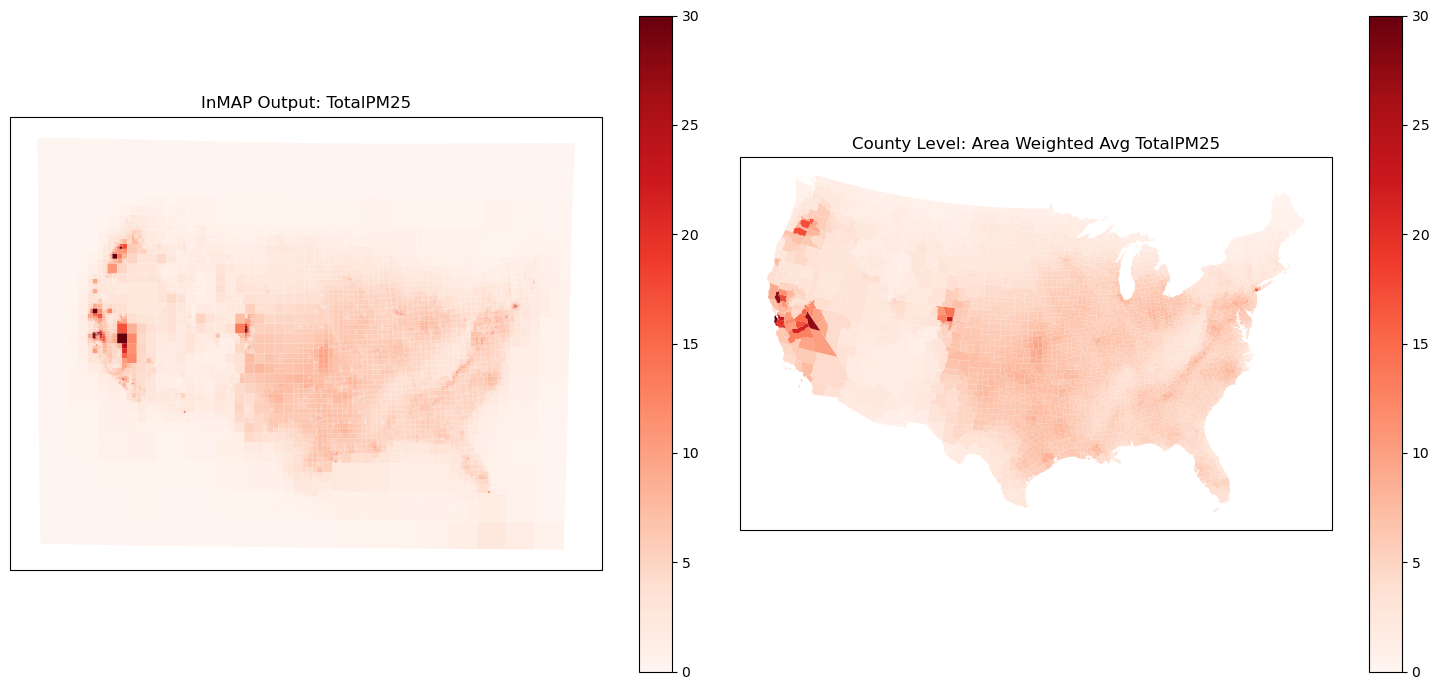

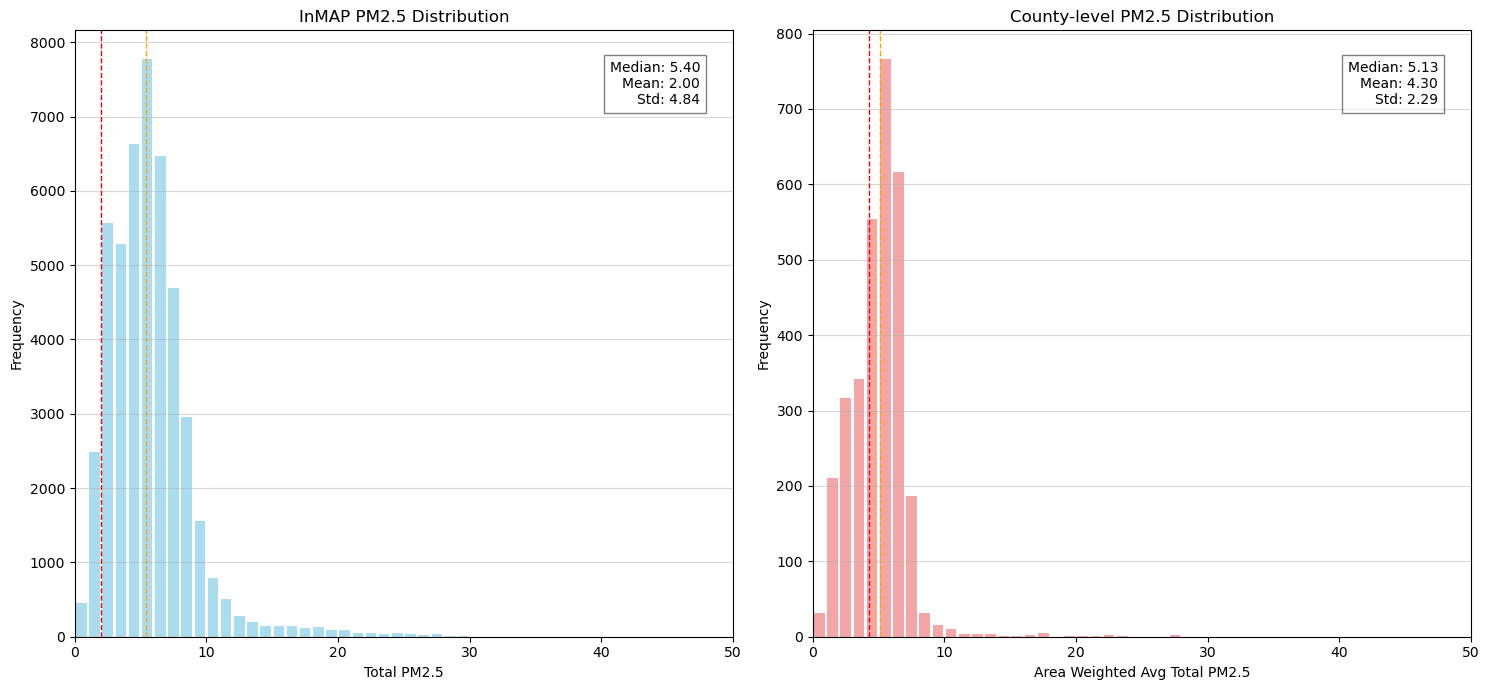

Processing InMAP output from directory: nei2020_LA_CCS
CRS of inmap: PROJCS["Lambert_Conformal_Conic",GEOGCS["GCS_unnamed ellipse",DATUM["unknown",SPHEROID["Unknown",6370997,0]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Lambert_Conformal_Conic_2SP"],PARAMETER["latitude_of_origin",40],PARAMETER["central_meridian",-97],PARAMETER["standard_parallel_1",33],PARAMETER["standard_parallel_2",45],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
CRS of gdf_fips before conversion: EPSG:4269
CRS of inmap after geographic conversion: +proj=aea +ellps=WGS84 +lon_0=-96 +lat_0=23 +x_0=0.0 +y_0=0.0 +lat_1=29.5 +lat_2=45.5 +no_defs +type=crs
CRS of gdf_fips after geographic conversion: +proj=aea +ellps=WGS84 +lon_0=-96 +lat_0=23 +x_0=0.0 +y_0=0.0 +lat_1=29.5 +lat_2=45.5 +no_defs +type=crs


/var/folders/c8/7t_s93rd22l4mk18hd7pj0d80000gn/T/ipykernel_39943/2122853041.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inmap_csv['Values'] = county_level_gdf['area_weighted_avg_TotalPM25']


Shapefile and CSV for /Users/yunhalee/Documents/LOCAETA/RCM/INMAP/inmap-1.9.6/outputs/nei2020_LA_CCS/2020nei_output_run_steady.shp have been saved successfully.
InMAP TotalPM25 min: 0.00413360663 max: 361.85062765692
County-level PM2.5 min: 0.4303104464918862 max: 52.34338933959698


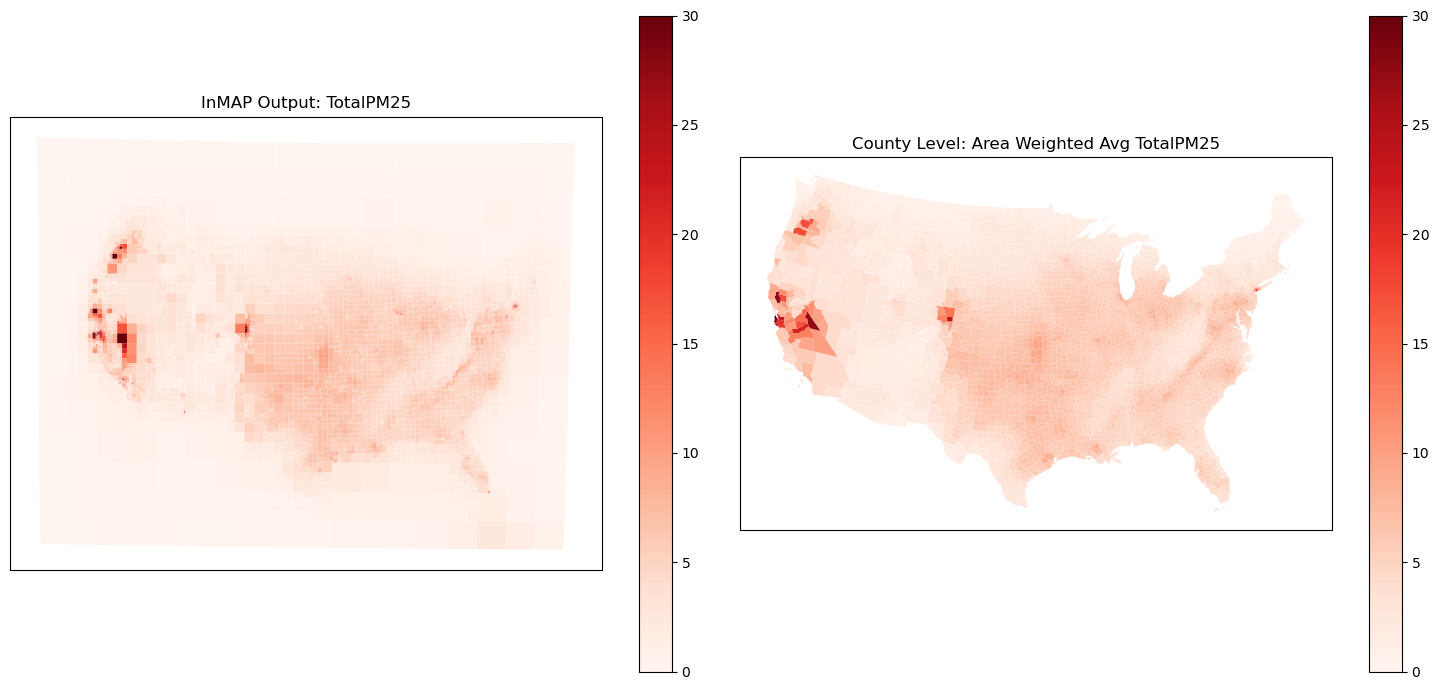

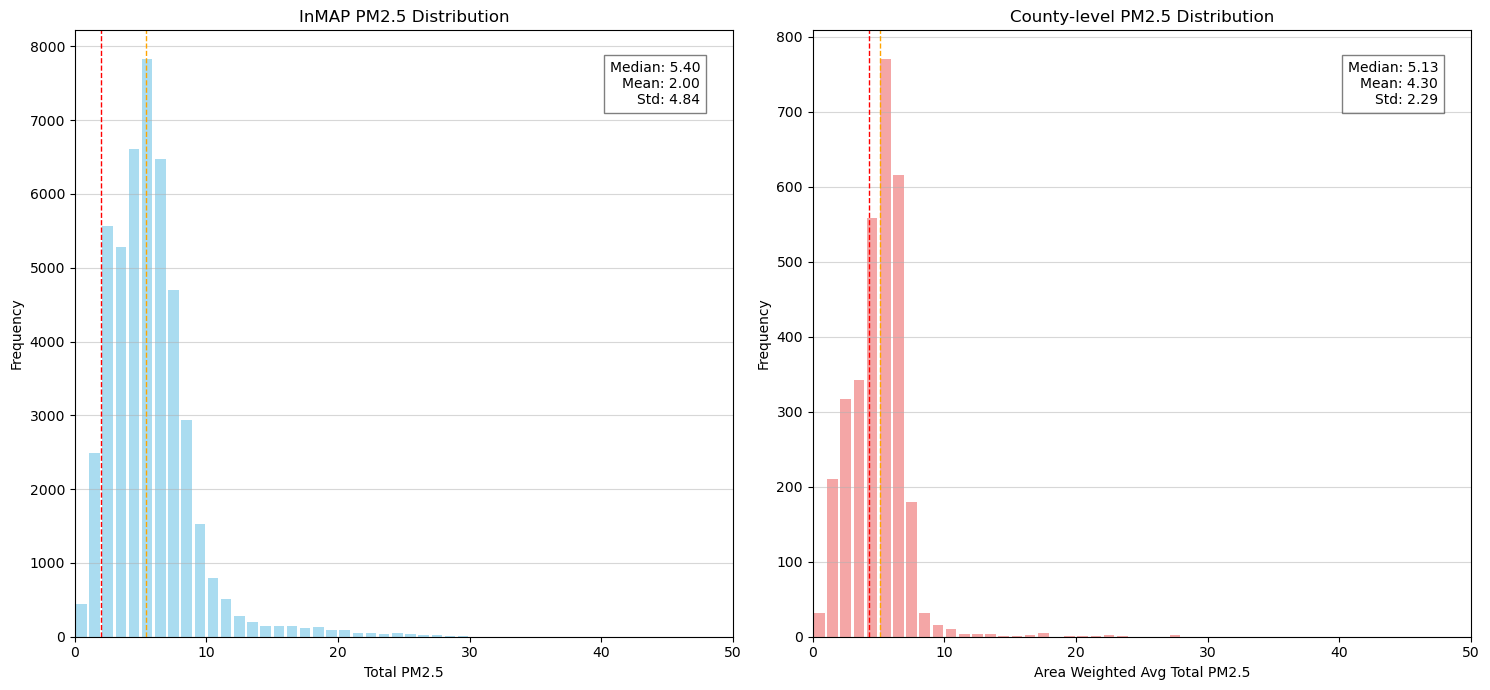

In [61]:
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np


def calculate_county_intersected_areas(inmap, gdf_fips):
    # Calculate the area of each grid cell
    inmap['grid_cell_area'] = inmap.geometry.area
    
    # Perform an intersection to calculate intersected areas
    inmap_with_fips = gpd.overlay(inmap, gdf_fips[['FIPS', 'geometry']], how='intersection')
    
    # Calculate the intersected area
    inmap_with_fips['intersected_area'] = inmap_with_fips.geometry.area
    
    return inmap_with_fips

def reshape_inmap_to_county_data(inmap_with_fips, gdf_fips):
    # Calculate the area-weighted TotalPM25
    inmap_with_fips['weighted_TotalPM25'] = inmap_with_fips['TotalPM25'] * inmap_with_fips['intersected_area']
    
    # Aggregate data at the county level
    county_level_data = inmap_with_fips.groupby('FIPS').agg({
        'weighted_TotalPM25': 'sum',
        'intersected_area': 'sum'
    }).reset_index()
    
    # Calculate the area-weighted average TotalPM25
    county_level_data['area_weighted_avg_TotalPM25'] = county_level_data['weighted_TotalPM25'] / county_level_data['intersected_area']
    
    # Calculate the actual area for each county
    gdf_fips['county_area'] = gdf_fips.geometry.area
    
    # Merge the aggregated data with the actual county areas
    county_level_data = county_level_data.merge(gdf_fips[['FIPS', 'county_area', 'geometry']], on='FIPS', how='left')
    
    # Compare intersected_area with actual county_area
    county_level_data['area_difference'] = county_level_data['intersected_area'] - county_level_data['county_area']
    
    return gpd.GeoDataFrame(county_level_data, geometry='geometry')

def save_AQ_csv(county_level_gdf, output_csv_path):
    # Prepare data for CSV
    county_level_gdf['Annual Metric'] = 'Mean'
    inmap_csv = county_level_gdf[['Row', 'Column', 'Annual Metric']]
    inmap_csv['Values'] = county_level_gdf['area_weighted_avg_TotalPM25']
    
    # Save as CSV
    inmap_csv.to_csv(output_csv_path, index=False)

def save_grid_shapefile(county_level_gdf, output_shapefile_path):
    # Save as new shapefile
    county_level_grid = county_level_gdf[['Row', 'Column', 'geometry']]
    county_level_grid.to_file(output_shapefile_path)

def process_inmap_to_benmap_inputs(inmap_output_path, county_shapefile_path, output_shapefile_path, output_csv_path):

    inmap = gpd.read_file(inmap_output_path)
    inmap = inmap[['geometry', 'TotalPM25']]
    
    gdf_fips = gpd.read_file(county_shapefile_path)
    gdf_fips['FIPS'] = gdf_fips['STATEFP'].astype(str) + gdf_fips['COUNTYFP'].astype(str)

    print("CRS of inmap:", inmap.crs)
    print("CRS of gdf_fips before conversion:", gdf_fips.crs)
    
    # BenMAP's preferred projection for area calculation
    projection = ccrs.AlbersEqualArea(central_longitude=-96, central_latitude=23, standard_parallels=(29.5, 45.5))
    
    gdf_fips =  gdf_fips.to_crs(projection) 
    inmap = inmap.to_crs(projection) 
    
    # Print CRS after conversion for debugging
    print("CRS of inmap after geographic conversion:", inmap.crs)
    print("CRS of gdf_fips after geographic conversion:", gdf_fips.crs)
    
    # Compute the intersection area for area-weighted concentrations
    inmap_with_fips = calculate_county_intersected_areas(inmap, gdf_fips)
    
    # Reshape INMAP grids to county-level 
    county_level_gdf = reshape_inmap_to_county_data(inmap_with_fips, gdf_fips)
    
    # Calculate centroids
    county_level_gdf['centroid'] = county_level_gdf.geometry.centroid
    county_level_gdf['centroid_x'] = county_level_gdf.centroid.x
    county_level_gdf['centroid_y'] = county_level_gdf.centroid.y
    
    # Sort by latitude (northing) then by longitude (easting)
    county_level_gdf = county_level_gdf.sort_values(by=['centroid_y', 'centroid_x'])
    
    # Assign Row and Column sequentially
    county_level_gdf = county_level_gdf.reset_index(drop=True)
    county_level_gdf['Row'] = (county_level_gdf.index // county_level_gdf.shape[1]) + 1
    county_level_gdf['Column'] = (county_level_gdf.index % county_level_gdf.shape[1]) + 1
    
    # Save shapefile and CSV
    save_grid_shapefile(county_level_gdf, output_shapefile_path)
    save_AQ_csv(county_level_gdf, output_csv_path)
    
    print(f"Shapefile and CSV for {inmap_output_path} have been saved successfully.")
    
    return inmap, county_level_gdf

def plot_pm25_original_and_reshaped_results(inmap, county_level_gdf, output_prefix, output_dir):

    # Debugging: Print the min and max of the PM2.5 values
    print("InMAP TotalPM25 min:", inmap['TotalPM25'].min(), "max:", inmap['TotalPM25'].max())
    print("County-level PM2.5 min:", county_level_gdf['area_weighted_avg_TotalPM25'].min(), "max:", county_level_gdf['area_weighted_avg_TotalPM25'].max())
    
    # Calculate statistics for InMAP
    inmap_min = inmap['TotalPM25'].min()
    inmap_max = inmap['TotalPM25'].max()
    inmap_median = inmap['TotalPM25'].median()
    inmap_std = inmap['TotalPM25'].std()
    inmap_mean = np.average(inmap['TotalPM25'], weights=inmap['grid_cell_area'])
    
    # Calculate statistics for County Level
    county_min = county_level_gdf['area_weighted_avg_TotalPM25'].min()
    county_max = county_level_gdf['area_weighted_avg_TotalPM25'].max()
    county_median = county_level_gdf['area_weighted_avg_TotalPM25'].median()
    county_std = county_level_gdf['area_weighted_avg_TotalPM25'].std()
    county_mean = np.average(county_level_gdf['area_weighted_avg_TotalPM25'], weights=county_level_gdf['intersected_area'])

    # Define figure and axes
    fig, axes = plt.subplots(1, 2, figsize=(15, 7), subplot_kw={'projection': ccrs.LambertConformal()})

    # InMAP Map
    inmap.plot(
        column='TotalPM25',
        cmap='Reds',
        legend=True,
        ax=axes[0],  # First row, first column
        vmin=0,
        vmax=30,
        transform=ccrs.LambertConformal()
    )
    axes[0].set_title('InMAP Output: TotalPM25')

    # County Level Map
    county_level_gdf = county_level_gdf.to_crs(ccrs.LambertConformal())
    county_level_gdf.plot(
        column='area_weighted_avg_TotalPM25',
        cmap='Reds',
        legend=True,
        ax=axes[1],  # First row, second column
        vmin=0,
        vmax=30,
        transform=ccrs.LambertConformal()
    )
    axes[1].set_title('County Level: Area Weighted Avg TotalPM25')

    plt.tight_layout()
    plt.savefig(f"{output_dir}{output_prefix}_PM25_maps.png")
    plt.show()

    # Calculate the bin edges for histograms
    bin_edges = np.linspace(0, 30, 31)  # 30 bins from 0 to 50

    # Define figure and axes for histograms
    fig_hist, ax_hist = plt.subplots(1, 2, figsize=(15, 7))

    # InMAP Histogram
    inmap_values = inmap['TotalPM25'].values
    ax_hist[0].hist(inmap_values, bins=bin_edges, color='skyblue', alpha=0.7, rwidth=0.8)
    ax_hist[0].set_title('InMAP PM2.5 Distribution')
    ax_hist[0].set_xlabel('Total PM2.5')
    ax_hist[0].set_ylabel('Frequency')
    ax_hist[0].set_xlim(0, 50)
    ax_hist[0].grid(axis='y', alpha=0.5)
    ax_hist[0].axvline(inmap_median, color='orange', linestyle='dashed', linewidth=1)
    ax_hist[0].axvline(inmap_mean, color='red', linestyle='dashed', linewidth=1)
    textstr = f'Median: {inmap_median:.2f}\nMean: {inmap_mean:.2f}\nStd: {inmap_std:.2f}'
    ax_hist[0].text(0.95, 0.95, textstr, transform=ax_hist[0].transAxes, fontsize=10,
                    verticalalignment='top', horizontalalignment='right', 
                    bbox=dict(facecolor='white', alpha=0.5))

    # County Level Histogram
    county_values = county_level_gdf['area_weighted_avg_TotalPM25'].values
    ax_hist[1].hist(county_values, bins=bin_edges, color='lightcoral', alpha=0.7, rwidth=0.8)
    ax_hist[1].set_title('County-level PM2.5 Distribution')
    ax_hist[1].set_xlabel('Area Weighted Avg Total PM2.5')
    ax_hist[1].set_ylabel('Frequency')
    ax_hist[1].set_xlim(0, 50)
    ax_hist[1].grid(axis='y', alpha=0.5)
    ax_hist[1].axvline(county_median, color='orange', linestyle='dashed', linewidth=1)
    ax_hist[1].axvline(county_mean, color='red', linestyle='dashed', linewidth=1)
    textstr = f'Median: {county_median:.2f}\nMean: {county_mean:.2f}\nStd: {county_std:.2f}'
    ax_hist[1].text(0.95, 0.95, textstr, transform=ax_hist[1].transAxes, fontsize=10,
                    verticalalignment='top', horizontalalignment='right', 
                    bbox=dict(facecolor='white', alpha=0.5))

    plt.tight_layout()
    plt.savefig(f"{output_dir}{output_prefix}_comparison.png")
    plt.show()

# main program # 

# County shape file path
county_shapefile_path = "/Users/yunhalee/Documents/LOCAETA/NEI_emissions/NEI_2020_gaftp_Jun2024/emiss_shp2020/Census/cb_2020_us_county_500k.shp"

inmap_output_dir = '/Users/yunhalee/Documents/LOCAETA/RCM/INMAP/inmap-1.9.6/outputs/'

# List of InMAP output files to process
inmap_outputs = [
   'nei2020/2020nei_output_run_steady.shp',
    'nei2020_LA_CCS/2020nei_output_run_steady.shp',
]

# Directory to save the grid and PM2.5 csv files, which are BenMAP input files
benmap_input_dir ='/Users/yunhalee/Documents/LOCAETA/RCM/BenMAP/immap_output/'


for inmap_output_path in inmap_outputs:

    inmap_runname = inmap_output_path.split('/')[0]  
    print(f"Processing InMAP output from directory: {inmap_runname}")

    output_shapefile_path = f'{benmap_input_dir}{inmap_runname}_county_level_inmap_grid.shp'
    output_csv_path = f'{benmap_input_dir}{inmap_runname}_county_level_inmap_PM25.csv'
    
    inmap, county_level_gdf = process_inmap_to_benmap_inputs(
        inmap_output_dir+inmap_output_path, 
        county_shapefile_path, 
        output_shapefile_path, 
        output_csv_path
    )
    
    plot_pm25_original_and_reshaped_results(inmap, county_level_gdf, inmap_runname, benmap_input_dir)


## Make BenMAP input files from INMAP output file (without reshaping)

In [1]:
import geopandas as gpd


inmap_output  = '/Users/yunhalee/Documents/LOCAETA/RCM/INMAP/inmap-1.9.6/outputs/nei2020/2020nei_output_run_steady.shp'

inmap = gpd.read_file(inmap_output)

inmap.head()

# Calculate centroids
inmap['centroid'] = inmap.geometry.centroid
inmap['centroid_x'] = inmap.centroid.x
inmap['centroid_y'] = inmap.centroid.y

# Sort by latitude (northing) then by longitude (easting)
inmap = inmap.sort_values(by=['centroid_y', 'centroid_x'])

# Assign Row and Column sequentially
inmap = inmap.reset_index(drop=True)
inmap['Row'] = (inmap.index // inmap.shape[1]) + 1
inmap['Column'] = (inmap.index % inmap.shape[1]) + 1

# Save as new shapefile
inmap_grid_path = '/Users/yunhalee/Documents/LOCAETA/RCM/BenMAP/immap_output/nei2020/inmap_grid.shp'
inmap_grid = inmap[['Row','Column','geometry']]
print(type(inmap_grid))
inmap_grid.to_file(inmap_grid_path)

# Prepare data for CSV
inmap['Annual Metric'] = 'Mean'
inmap_csv = inmap[['Row', 'Column', 'Annual Metric']]
inmap_csv['Values'] = inmap['TotalPM25']

# Save as CSV
inmap_csv_path = '/Users/yunhalee/Documents/LOCAETA/RCM/BenMAP/immap_output/nei2020/inmap_PM25.csv'
inmap_csv.to_csv(inmap_csv_path, index=False)

print("Shapefile and CSV have been saved successfully.")

Warning 3: Cannot find header.dxf (GDAL_DATA is not defined)


,AsianD,BasePM25,BlackD,LatinoD,NH3,NOx,NativeD,PNH4,PNO3,PSO4,PrimPM25,SOA,SOx,TotalPM25,TotalPop,TotalPopD,WhitNoLatD,WindSpeed,geometry
0,0.0,1.894995,0.0,0.0,0.000064,0.079614,0.0,0.014100,0.003353,0.004324,0.010752,0.020774,0.000189,0.053304,0.0,0.0,0.0,6.438056,"POLYGON ((-2736000.000 -2088000.000, -2448000...."
1,0.0,1.998746,0.0,0.0,0.000117,0.121549,0.0,0.020574,0.007156,0.007063,0.017120,0.030469,0.001462,0.082381,0.0,0.0,0.0,6.224479,"POLYGON ((-2736000.000 -1800000.000, -2448000...."
2,0.0,2.011189,0.0,0.0,0.000224,0.148216,0.0,0.024841,0.009412,0.009063,0.022835,0.035573,0.002887,0.101723,0.0,0.0,0.0,6.144984,"POLYGON ((-2736000.000 -1512000.000, -2448000...."
3,0.0,1.979012,0.0,0.0,0.000338,0.152132,0.0,0.027300,0.008132,0.009908,0.027468,0.035315,0.002733,0.108123,0.0,0.0,0.0,6.259710,"POLYGON ((-2736000.000 -1224000.000, -2448000...."
4,0.0,1.964202,0.0,0.0,0.000582,0.176409,0.0,0.031896,0.009103,0.012526,0.036375,0.036534,0.004135,0.126433,0.0,0.0,0.0,6.402865,"POLYGON ((-2736000.000 -936000.000, -2448000.0..."


In [31]:
county_level_gdf.head()

,Row,Column,area_weigh,geometry
0,1,1,3.619757,"MULTIPOLYGON (((-80.29650 25.32684, -80.29543 ..."
1,1,2,3.686799,"MULTIPOLYGON (((-80.30352 25.38012, -80.30162 ..."
2,1,3,3.961988,"POLYGON ((-81.84578 26.33038, -81.84105 26.330..."
3,1,4,2.443034,"MULTIPOLYGON (((-97.24311 26.41118, -97.24035 ..."
4,1,5,4.125214,"POLYGON ((-80.88129 26.33381, -80.77640 26.334..."
